In [6]:
!pip install  --quiet langgraph
!pip install  --quiet langchain-google-genai
!pip install --quiet langchain
!pip install --quiet tavily-python
!pip install --quiet langchain_community
!pip install --quiet wikipedia
!pip install --quiet google-generativeai

In [38]:
from google.colab import userdata
from IPython.display import Image, display, Markdown
import textwrap
import os
import getpass

from typing import Any, Annotated, List, TypedDict
from pydantic import BaseModel, Field

from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import get_buffer_string, AIMessage, HumanMessage, SystemMessage
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.document_loaders import WikipediaLoader

from langgraph.graph import MessagesState
from langgraph.graph.state import StateGraph, END, START
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph.message import add_messages

In [9]:
google_api_key = userdata.get('GOOGLE_API_KEY')

model = ChatGoogleGenerativeAI(model="gemini-1.5-flash",
                              api_key=google_api_key
                              )

# model.invoke("Test")

In [41]:
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("TAVILY_API_KEY")

TAVILY_API_KEY: ··········


In [39]:
memory = MemorySaver()

class State(TypedDict):
  topic: str
  pro_debator: str
  anti_debator: str
  greetings: str
  sentiment: str
  analysis: str
  pro_debator_response: str
  anti_debator_response: str
  context: Annotated[list, add_messages]
  debate: Annotated[list, add_messages]
  debate_history: List[str]
  iteration: int

class SearchQuery(BaseModel):
  search_query: str = Field(description="The search query for retrieval")

In [48]:
def greeting_node(state: State):
  """LangGraph node that greets the debators and introduces them"""
  topic = state['topic']
  pro_debator = state['pro_debator']
  anti_debator = state['anti_debator']

  prompt = f"""You are hosting a debate between {pro_debator} and {anti_debator}
            on the topic {topic}. {pro_debator} is pro while {anti_debator} is
            against. You have to introduce the topic and debators to the audience.
            Your response should be short and conversational
            """

  greetings = model.invoke(prompt).content
  return {"greetings": greetings}


def analyzer_node(state: State):
    """LangGraph node that analyzes the latest argument for web search"""
    topic = state['topic']
    debate = state['debate']
    pro_debator = state['pro_debator']
    anti_debator = state['anti_debator']
    last_message = debate[-1]
    analysis_prompt = None
    if isinstance(last_message, HumanMessage):
        # Generate a prompt for a HumanMessage (pro-debator)
        analysis_prompt = f"""
        Analyze the latest argument made by the pro-debator {pro_debator}  on the topic "{topic}".
        Focus on its strengths, weaknesses, and logical coherence. Write a short and concise
        analytical guidance that can be used for web search to help {anti_debator} better answer the argument
        and more completely support their stance on the topic {topic}
        **Pro-Debator's Argument:**
        {last_message.content}
        """

    elif isinstance(last_message, AIMessage):
        # Generate a prompt for an AIMessage (anti-debator)
        analysis_prompt = f"""
        Analyze the latest counterargument made by the anti-debator {anti_debator} on the topic "{topic}".
        Identify key points of contention and evaluate their validity.  Write a short and concise
        analytical guidance that can be used for web search to help {anti_debator} to effectively refute these arguments
        and more completely support their stance on the topic {topic}
        **Anti-Debator's Counterargument:**
        {last_message.content}
        """

    analysis = model.invoke(analysis_prompt).content
    return {"analysis": analysis}


def search_web(state: State):
    """ Retrieve docs from web search """
    # Search query
    analysis = state['analysis']
    search_query = model.with_structured_output.invoke([analysis]+state['messages'])
    # Search
    tavily_search = TavilySearchResults(max_results = 3)
    search_docs = tavily_search.invoke(search_query.search_query)
     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )
    return {"context": [formatted_search_docs]}


def search_wikipedia(state: State):
    """ Retrieve docs from wikipedia """
    # Search query
    analysis = state['analysis']
    search_query = model.with_structured_output.invoke([analysis]+state['messages'])
    # Search
    search_docs = WikipediaLoader(query=search_query.search_query,
                                  load_max_docs=2).load()
     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )
    return {"context": [formatted_search_docs]}


def router(state: State):
    """LangGraph node that routes to the appropriate search function"""
    debate_history = state["debate_history"]
    if debate_history == []:
        return "Pro Debator"
    else:
      return "Analyzer"

In [56]:
from langchain_core.messages import HumanMessage

def pro_debator_node(state: State):
    """LangGraph node that represents the pro debator"""
    topic = state['topic']
    anti_debator_response = state['anti_debator_response']
    pro_debator = state['pro_debator']
    anti_debator = state['anti_debator']
    debate_history = state['debate_history']
    debate = state['debate']

    if anti_debator_response is None and debate == []:
        prompt_template = """
            You are {pro_debator}, a pro debator on the topic of {topic} having a debate with {anti_debator}.
            Your goal is to present compelling arguments in favor of {topic} while maintaining the persona of {pro_debator}.
            Ensure your responses are coherent, logical, and persuasive.
            Keep the persona of {pro_debator} throughout the entire conversation.
            Your responses should be relevant to the current stage of the debate.
            You can refute the other debator's arguments and present your own supporting evidence for {topic}.
            Do not deviate from your persona. Respond concisely in no more than 4 or 5 sentences.
        """
        system_message = prompt_template.format(topic=topic, pro_debator=pro_debator, anti_debator=anti_debator)
        pro_debator_response_content = model.invoke(system_message).content
    else:
      context = state['context']
      prompt_template = """
          You are a professional debater, embodying the persona of {pro_debator}. Your goal is to convincingly argue the affirmative side of the debate topic: "{topic}".
          You must maintain your assigned persona throughout the debate and ensure that your arguments align with it.
          Remember the following:
          1. Respond to the latest argument of the anti-debator provided below, ensuring your response directly addresses their points.
          2. Consider the context of the debate history {debate_history} and data gathered from web search {context}, building upon your
          previous arguments and refuting the anti-debator's counterarguments effectively.
          3. Use eloquent and persuasive language, demonstrating your mastery of the topic and your persona.
          4. Avoid making factual errors or inconsistencies that might damage your credibility.
          **Debate History:**
          {debate_history}
          **Latest Anti-Debator Argument:**
          {anti_debator_response}
          **Your Response (Pro Debator):**
      """
      system_message = prompt_template.format(
          topic=topic,
          pro_debator=pro_debator,
          anti_debator=anti_debator,
          debate_history=debate_history,
          anti_debator_response=anti_debator_response,
          context=context
      )
      pro_debator_response_content = model.invoke(system_message).content

    # Create a HumanMessage with the response content and assign a name
    pro_debator_response = HumanMessage(
        content=pro_debator_response_content,
        name="pro_response"
    )

    debate.append(pro_debator_response)
    return {"pro_debator_response": pro_debator_response, "debate": debate}


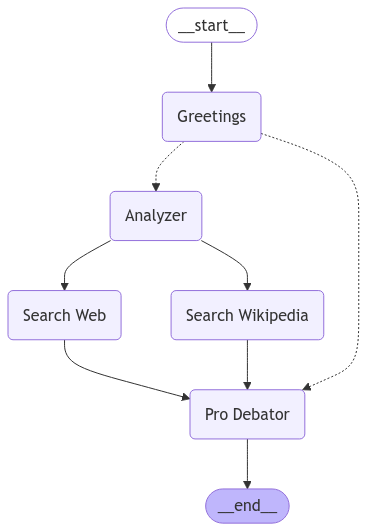

In [57]:
builder: StateGraph = StateGraph(State)

builder.add_node("Greetings", greeting_node)
builder.add_node("Pro Debator", pro_debator_node)
builder.add_node("Analyzer", analyzer_node)
builder.add_node("Search Web", search_web)
builder.add_node("Search Wikipedia", search_wikipedia)

builder.add_edge(START, "Greetings")
builder.add_conditional_edges("Greetings", router, ['Analyzer', 'Pro Debator'])
builder.add_edge("Analyzer", "Search Web")
builder.add_edge("Analyzer", "Search Wikipedia")
builder.add_edge("Search Web", 'Pro Debator')
builder.add_edge("Search Wikipedia", 'Pro Debator')
builder.add_edge("Pro Debator", END)

debator = builder.compile(checkpointer=memory).with_config(run_name="Create podcast")

display(Image(debator.get_graph().draw_mermaid_png()))

In [58]:
thread = {"configurable": {"thread_id": "1"}}
result = debator.invoke({'topic': 'Ukraine War', 'pro_debator': 'Joe Biden', 'anti_debator': 'Donald Trump', 'anti_debator_response': None, 'debate_history': [], 'debate':[], 'context': ""}, thread)
result

{'topic': 'Ukraine War',
 'pro_debator': 'Joe Biden',
 'anti_debator': 'Donald Trump',
 'greetings': "Good evening, ladies and gentlemen, and welcome to tonight's crucial debate on a matter of paramount importance to global security and the future of democracy: the war in Ukraine.  For months, the world has watched with bated breath as Russia’s unprovoked invasion has unfolded, causing immense human suffering and threatening the very foundations of the international order.  Tonight, we will delve into the complexities of this conflict, exploring its origins, its impact, and the best path forward.\n\nOur debaters tonight represent two distinctly different perspectives on this critical issue.  On one side, we have President Joe Biden, who has championed a robust and unwavering support for Ukraine, providing significant military and economic aid to help them defend their sovereignty against Russian aggression.  President Biden will be arguing in favor of continued and potentially increase